#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

**Импортируем библиотеки для работы с данными.**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

**Считаем данные из csv-файла train_job_satisfaction_rate.csv в датафрейм, сохраним в переменную и выведем несколько первых строк. Выведем общую информацию загруженного датафрейма.**

In [2]:
pth = '/datasets/taxi.csv'

if os.path.exists(pth):
    taxi = pd.read_csv(pth, sep=',', index_col=['datetime'], parse_dates=['datetime'])
else:
    print('Something is wrong')

display(taxi)
taxi.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Выполним ресемплирование данных по одному часу.**

In [3]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()

**Убедимся в корректности сортировки индексов.**

In [4]:
print('Минимальное значение даты: ', taxi.index.min(), '. Первое значение: ',taxi.index[0])
print('Максимальное значение даты: ', taxi.index.max(), '. Последнее значение: ', taxi.index[-1])
print(taxi.index.is_monotonic)

Минимальное значение даты:  2018-03-01 00:00:00 . Первое значение:  2018-03-01 00:00:00
Максимальное значение даты:  2018-08-31 23:00:00 . Последнее значение:  2018-08-31 23:00:00
True


У нас присутствуют данные за 2018 год с марта по август включительно.

## Анализ

**Разложим временной ряд на тренд и сезонную компоненту.**

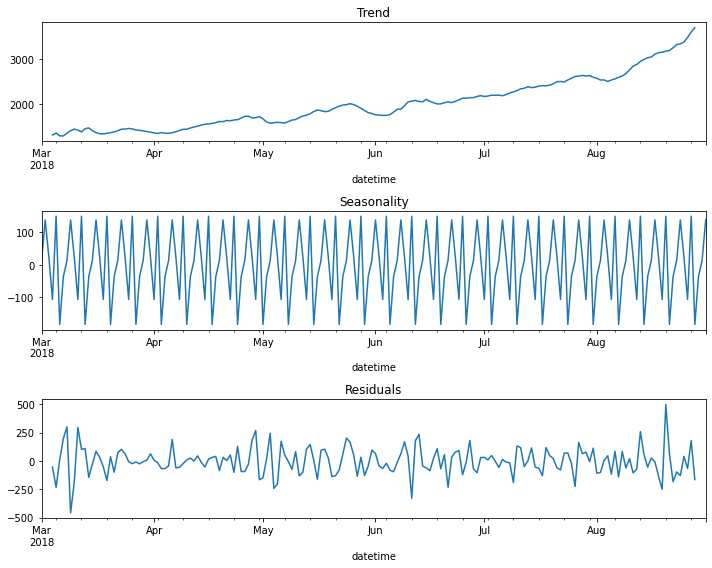

In [5]:
taxi_daily = taxi.resample('1D').sum()

plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed = seasonal_decompose(taxi_daily['num_orders'], model='additive', period=7)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Проведем анализ полученных данных. Построим график количества заказов такси со скользящим средним и медианой.**

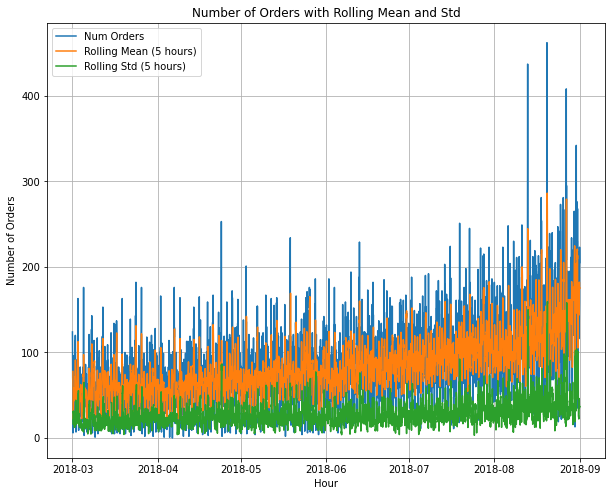

In [6]:
taxi['mean'] = taxi['num_orders'].rolling(5).mean()
taxi['std'] = taxi['num_orders'].rolling(5).std()

plt.figure(figsize=(10, 8))
plt.plot(taxi.index, taxi['num_orders'], label='Num Orders')
plt.plot(taxi.index, taxi['mean'], label='Rolling Mean (5 hours)')
plt.plot(taxi.index, taxi['std'], label='Rolling Std (5 hours)')

plt.xlabel('Hour')
plt.ylabel('Number of Orders')
plt.title('Number of Orders with Rolling Mean and Std')
plt.legend()
plt.grid(True)
plt.show()

По графику не очень понятно наличие стационарности.

**Проверим стационарность модели тестом Дики-Фуллера.**

In [7]:
# Применение теста Дики-Фуллера
result = adfuller(taxi['num_orders'])

# Вывод результатов теста
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Интерпретация результатов
if result[1] < 0.05:
    print("Временной ряд стационарен (отвергаем нулевую гипотезу).")
else:
    print("Временной ряд нестационарен (не можем отвергнуть нулевую гипотезу).")

ADF Statistic: -3.0689242890279558
p-value: 0.028940051402612906
Critical Values:
   1%: -3.431842162413052
   5%: -2.8621993540813637
   10%: -2.567120978470452
Временной ряд стационарен (отвергаем нулевую гипотезу).


Таким образом, на основании результатов теста Дики-Фуллера можно заключить, что ваш временной ряд стационарен.

## Обучение

**Визуализируем корреляцию признаков для нахождения лучшего доп. признака с помощью метода plot_acf**

<Figure size 720x576 with 0 Axes>

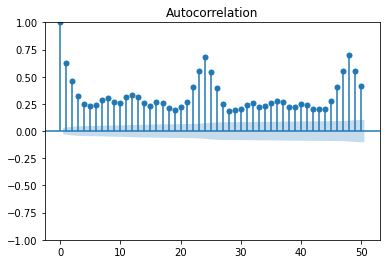

In [8]:
# Визуализация автокорреляционной функции (ACF)
plt.figure(figsize=(10, 8))
plot_acf(taxi['num_orders'].dropna(), lags=50)
plt.show()

Судя по графику нам подойдет значение 24, потом идет дублирование.

**Создадим признаки для горизонта прогнозирования в один шаг.**

,num_orders,mean,std,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,2,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,77.8,29.928248,4,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,174.6,45.478566,19,4,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,182.2,35.266131,20,4,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,174.6,35.373719,21,4,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


<Figure size 720x576 with 0 Axes>

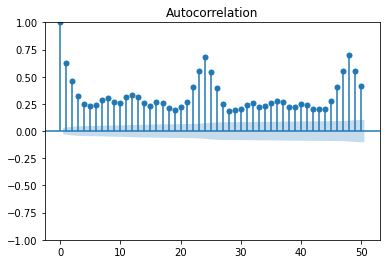

In [9]:
# Определяем функцию make_features
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

# На основании графика ACF выбираем max_lag и rolling_mean_size
make_features(taxi, max_lag=24, rolling_mean_size=24)

display(taxi)

# Пример анализа автокорреляций
plt.figure(figsize=(10, 8))
plot_acf(taxi['num_orders'].dropna(), lags=50)
plt.show()

**Разделим данные на обучающую и тестовую выборки.**

In [10]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(columns=['num_orders'])
y_train = train['num_orders']
X_test = test.drop(columns=['num_orders'])
y_test = test['num_orders']

**Обучим модели линейной регрессии GradientBoostingRegressor и RandomForestRegressor. Выберем лучшую.**

In [11]:
all_features = taxi.columns.tolist()
numeric_features = [feature for feature in all_features if feature not in ['hour', 'dayofweek', 'num_orders']]

# Определяем категориальные признаки
categorical_features = ['hour', 'dayofweek']

# Создаем трансформер для предобработки
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OrdinalEncoder(), categorical_features)
    ])

# Создаем пайплайн
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor())
])

# Создаем сетку гиперпараметров для обеих моделей
param_grid = [
    {
        'model': [GradientBoostingRegressor(random_state=42)],
        'model__learning_rate': [0.1, 0.2],
        'model__n_estimators': [30, 50, 70],
        'model__max_depth': [20, 30, 40]
    },
    {
        'model': [RandomForestRegressor(random_state=42)],
        'model__n_estimators': [30, 50, 70],
        'model__max_depth': [20, 30, 40]
    }
]

# Создаем GridSearchCV для поиска лучших гиперпараметров
tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_root_mean_squared_error', cv=tscv)
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры и оценку на тестовом наборе
print("Best Parameters:", grid_search.best_params_)
print("Best MRSE:", -grid_search.best_score_)

Best Parameters: {'model': RandomForestRegressor(max_depth=20, n_estimators=70, random_state=42), 'model__max_depth': 20, 'model__n_estimators': 70}
Best MRSE: 22.626404618791884


Лучшей моделью оказалась RandomForestRegressor с метрикой RMSE 22.62 на тренировочной выборке.

## Тестирование

**Предскажем тестовые данные и расчитаем метрику RMSE.**

In [12]:
# Предсказание на тестовом наборе с помощью лучшей модели
test_predictions = grid_search.predict(X_test)

# Вычисление метрики RMSE
rmse = mean_squared_error(y_test, test_predictions, squared=False)
print("Test RMSE:", rmse)

Test RMSE: 36.18983268687636


Выводы:
- Гиперпараметры: Модель RandomForestRegressor с параметрами max_depth=20 и n_estimators=70 показала наилучшие результаты при кросс-валидации.
- Качество модели: Значение RMSE на тестовом наборе (36.19) выше, чем на тренировочном наборе (22.63), что может указывать на некоторое переобучение модели или различия в структуре данных между тренировочным и тестовым наборами.
- Обоснованность метрики: RMSE является подходящей метрикой для данной задачи, так как она измеряет среднеквадратичное отклонение между прогнозируемыми и фактическими значениями, что важно для понимания точности модели в реальных числах заказов такси.

Таким образом, модель показала хорошие результаты, но есть потенциал для дальнейшего улучшения предсказательной способности.